# Plots for Near-Optimal Analysis
***

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from vresutils.snakemake import MockSnakemake, Dict
from itertools import product
import os

In [3]:
from plotting import collection as clt

In [4]:
plt.style.use('bmh')
%matplotlib inline

## Preliminaries

In [5]:
clusters = 200
d = f"../graphics/{clusters}/"

In [6]:
if not os.path.exists(d):
    os.makedirs(d)

In [7]:
snakemake = MockSnakemake(
    input=Dict(
        investments=f"results/summaries/{clusters}/investments.csv",
        energy=f"results/summaries/{clusters}/energy.csv",
        storage_capacity=f"results/summaries/{clusters}/storage_capacity.csv",
        generation_capacity=f"results/summaries/{clusters}/generation_capacity.csv",
        line_capacity=f"results/summaries/{clusters}/line_capacity.csv",
        link_capacity=f"results/summaries/{clusters}/link_capacity.csv",
        line_volume=f"results/summaries/{clusters}/line_volume.csv",
        link_volume=f"results/summaries/{clusters}/link_volume.csv",
        line_energy_balance=f"results/summaries/{clusters}/line_energy_balance.csv",
        link_energy_balance=f"results/summaries/{clusters}/link_energy_balance.csv",
        ginis=f"results/summaries/gini.csv",
        network=f"results/networks/elec_s_{clusters}_ec_lcopt_2H.nc",
        network_tmin1=f"results/networks/elec_s_{clusters}_ec_lcopt_2H_tol0.01_cat-totals_obj-Transmission++min.nc",
        network_tmin5=f"results/networks/elec_s_{clusters}_ec_lcopt_2H_tol0.05_cat-totals_obj-Transmission++min.nc",
        network_tmin10=f"results/networks/elec_s_{clusters}_ec_lcopt_2H_tol0.1_cat-totals_obj-Transmission++min.nc",
        shapes=f"pypsa-eur/resources/regions_onshore_elec_s_{clusters}.geojson"
    )
)

## Read Data

In [8]:
header = [i for i in range(7)]
investments = pd.read_csv(snakemake.input.investments, index_col=0, header=header)
energy=pd.read_csv(snakemake.input.energy, index_col=[0,1], header=header)
storage_capacity=pd.read_csv(snakemake.input.storage_capacity, index_col=[0,1], header=header)
generation_capacity=pd.read_csv(snakemake.input.generation_capacity, index_col=[0,1], header=header)
line_capacity=pd.read_csv(snakemake.input.line_capacity, index_col=0, header=header)
link_capacity=pd.read_csv(snakemake.input.link_capacity, index_col=0, header=header)
line_volume=pd.read_csv(snakemake.input.line_volume, index_col=0, header=header)
link_volume=pd.read_csv(snakemake.input.link_volume, index_col=0, header=header)
line_energy_balance=pd.read_csv(snakemake.input.line_energy_balance, index_col=0, header=header)
link_energy_balance=pd.read_csv(snakemake.input.link_energy_balance, index_col=0, header=header);

FileNotFoundError: [Errno 2] No such file or directory: '../results/summaries/200/investments.csv'

In [9]:
def adjust_column_names(df):
    new_column_names = []
    for col in df.columns.tolist():
        col = list(col)  # tuple does not allow item assignment
        if col[-2] == "all":
            col[-2] = "-".join([col[-2], col[-3]])
        new_column_names.append(tuple(col))

    df.columns = pd.MultiIndex.from_tuples(new_column_names, names=df.columns.names)

In [10]:
for df in [
    investments,
    line_volume,
    link_volume,
    generation_capacity,
    storage_capacity,
    energy,
]:
    adjust_column_names(df)

In [11]:
def read_gini(gini_fn, ln_vol, lk_vol):
    tvol = (ln_vol.sum()/1e3 + lk_vol.sum()/1e3).reset_index()
    gini = pd.read_csv(gini_fn, index_col=0, header=header).T.reset_index()
    gini = pd.concat([gini,tvol[0]], axis=1)
    gini = gini.rename(columns={0: 'tvol'})
    return gini.loc[gini.variable_name=='all']

In [12]:
gini = read_gini(snakemake.input.ginis, line_volume, link_volume)

In [13]:
n = pypsa.Network(snakemake.input.network)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_2H.nc has buses, carriers, generators, lines, links, loads, storage_units


In [14]:
n_tmin1 = pypsa.Network(snakemake.input.network_tmin1)
n_tmin5 = pypsa.Network(snakemake.input.network_tmin5)
n_tmin10 = pypsa.Network(snakemake.input.network_tmin10)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_2H_tol0.01_cat-totals_obj-Transmission++min.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_2H_tol0.05_cat-totals_obj-Transmission++min.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_2H_tol0.1_cat-totals_obj-Transmission++min.nc has buses, carriers, generators, lines, links, loads, storage_units


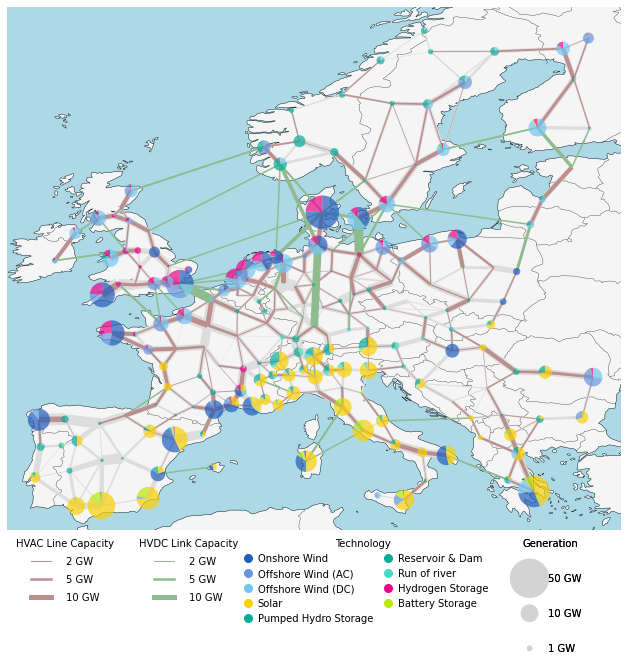

In [15]:
clt.plot_network(n, fn=f"{d}map-opt.pdf")

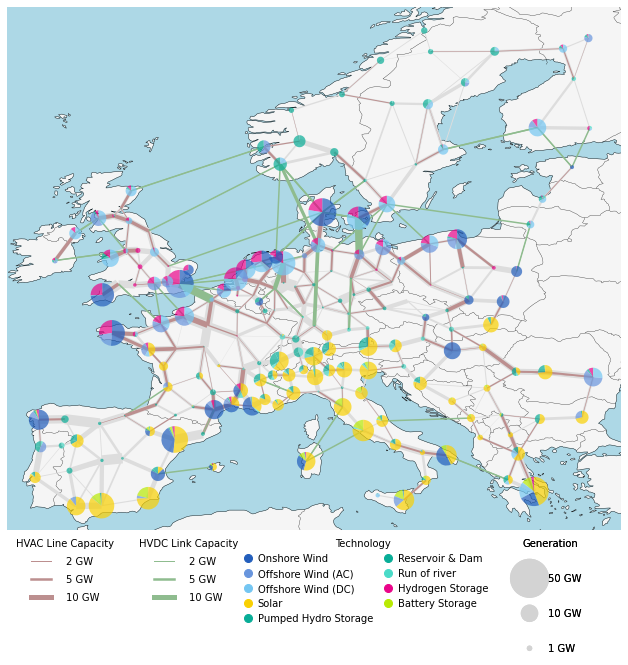

In [16]:
clt.plot_network(n_tmin1, fn=f"{d}map-tmin1.pdf")

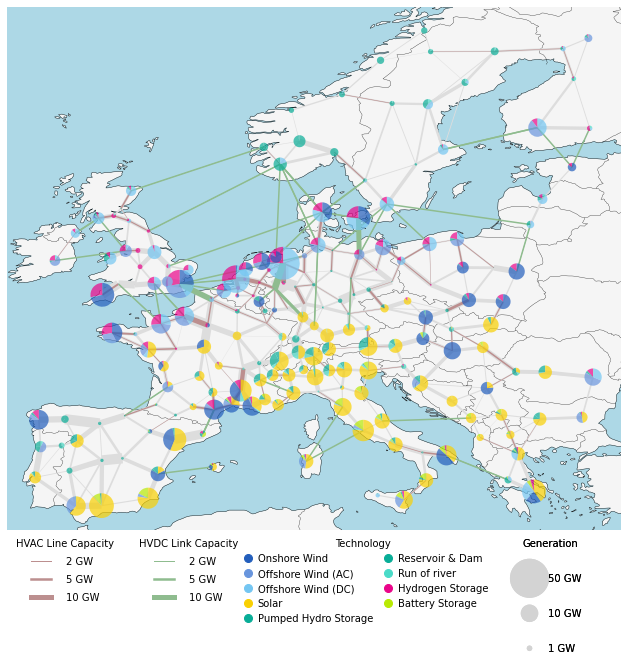

In [17]:
clt.plot_network(n_tmin5, fn=f"{d}map-tmin5.pdf")

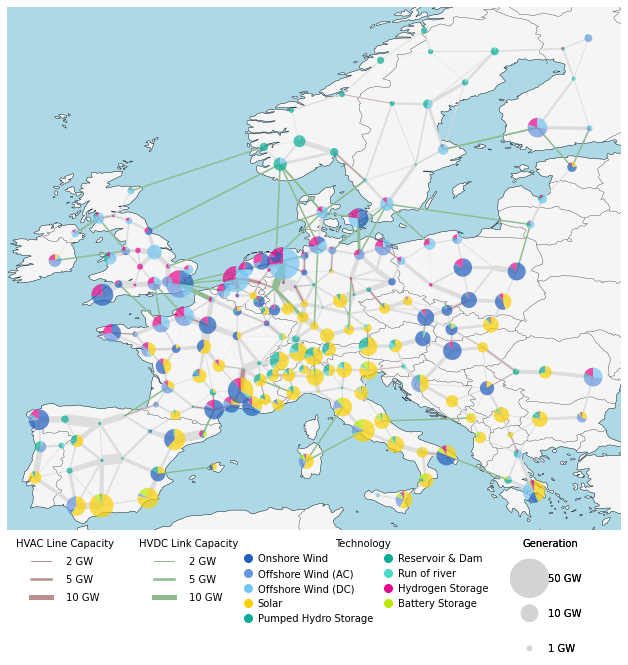

In [18]:
clt.plot_network(n_tmin10, fn=f"{d}map-tmin10.pdf")

In [19]:
shapes = gpd.read_file(snakemake.input.shapes)

## Execute Plotting Functions

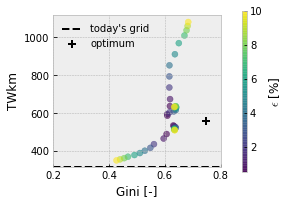

In [20]:
clt.plot_gini(gini, n, annot={}, fn=f"{d}gini.pdf")

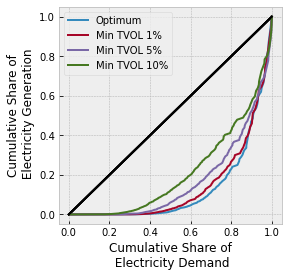

In [21]:
lorentz_networks = {"Optimum": n, "Min TVOL 1%": n_tmin1, "Min TVOL 5%": n_tmin5, "Min TVOL 10%": n_tmin10}
clt.plot_lorentz(lorentz_networks, fn=f"{d}lorentz.pdf")

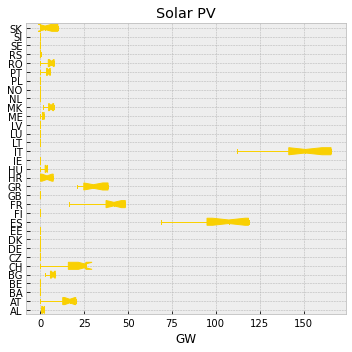

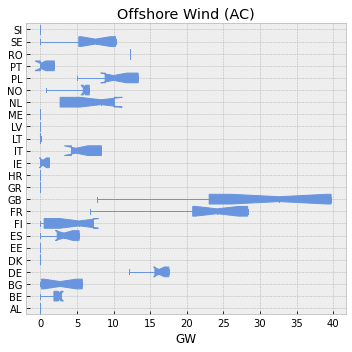

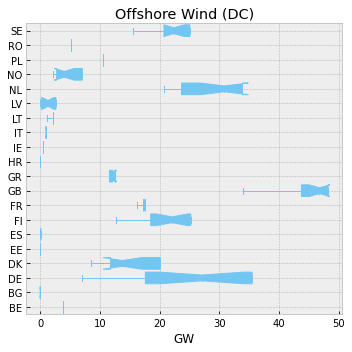

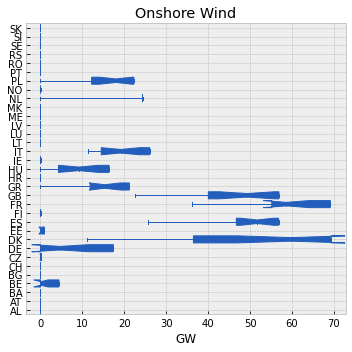

In [22]:
for c in ["solar", "offwind-ac", "offwind-dc", "onwind"]:
    clt.plot_curated_boxplots(generation_capacity, carrier=c, fn=f"{d}boxplots-{c}.pdf")

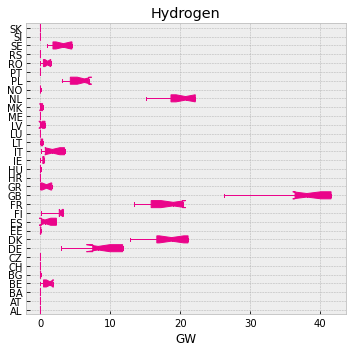

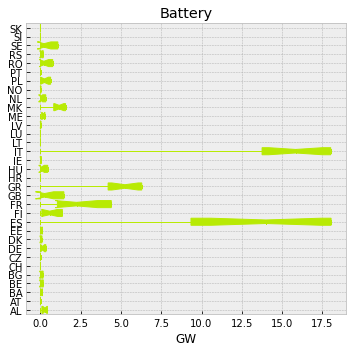

In [23]:
for c in ["H2", "battery"]:
    clt.plot_curated_boxplots(storage_capacity, carrier=c, fn=f"{d}boxplots-{c}.pdf")

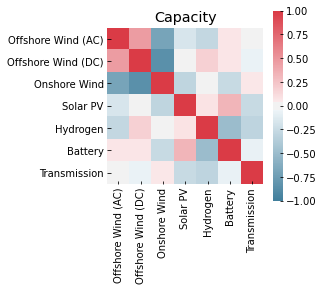

In [24]:
clt.plot_capacity_correlation(generation_capacity, storage_capacity, line_volume, link_volume, fn=f"{d}capacity-correlation.pdf")

In [25]:
clt.plot_energy_correlation(energy, fn=f"{d}energy-correlation.pdf")

In [26]:
clt.plot_violins(generation_capacity, storage_capacity, fn=f"{d}violins.pdf")

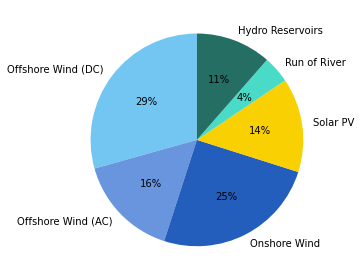

In [27]:
clt.plot_energy_pie(n, fn=f"{d}energy-pie.pdf")

/home/ws/sp2668/bwss/playgrounds/pypsa-eur-mga/scripts/plotting/bar.py:75: MatplotlibDeprecationWarning:

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.



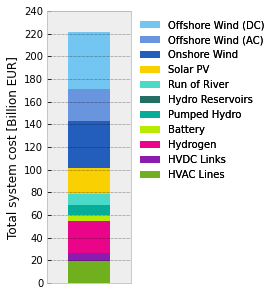

In [28]:
clt.plot_cost_bar(n, order=True, relative=False, fn=f"{d}cost-bar-abs.pdf")

/home/ws/sp2668/bwss/playgrounds/pypsa-eur-mga/scripts/plotting/bar.py:75: MatplotlibDeprecationWarning:

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.



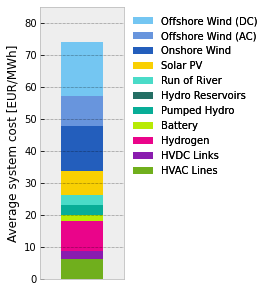

In [29]:
clt.plot_cost_bar(n, order=True, relative=True, fn=f"{d}cost-bar-rel.pdf")

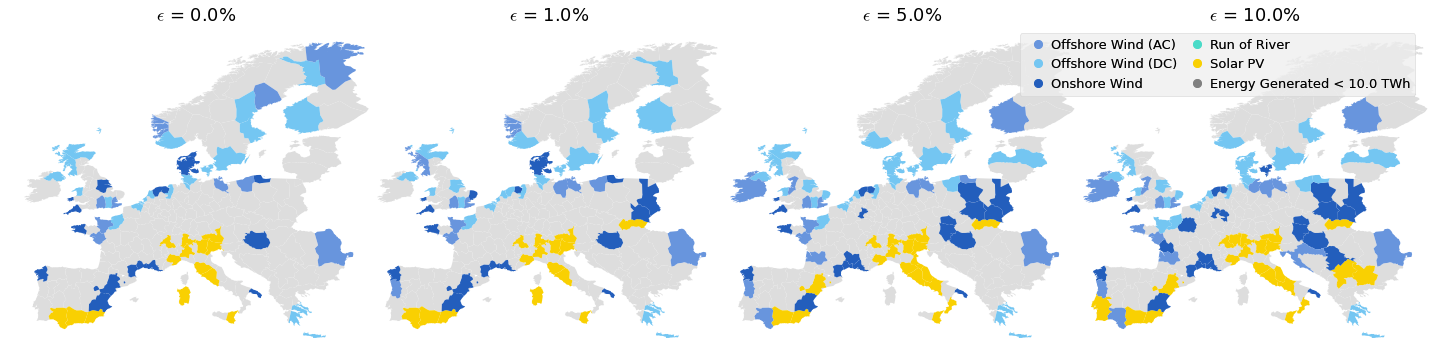

In [30]:
clt.plot_dominance(n, n_tmin1, n_tmin5, n_tmin10, shapes=shapes, attr='energy', fn=f"{d}dominance-energy.pdf")

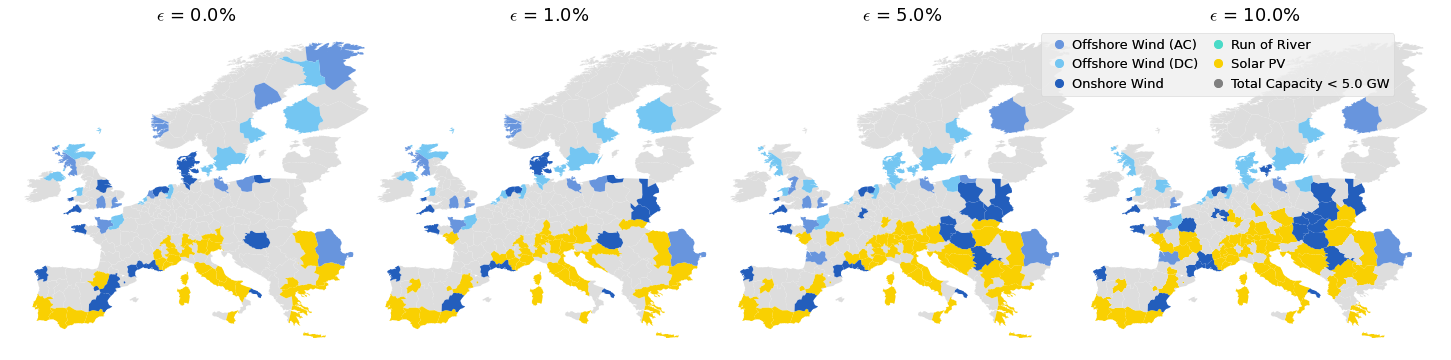

In [31]:
clt.plot_dominance(n, n_tmin1, n_tmin5, n_tmin10, shapes=shapes, attr='p_nom_opt', fn=f"{d}dominance-capacity.pdf")

In [32]:
clt.plot_bar_collection(generation_capacity, storage_capacity, fn=f"{d}capacity-bars.pdf")

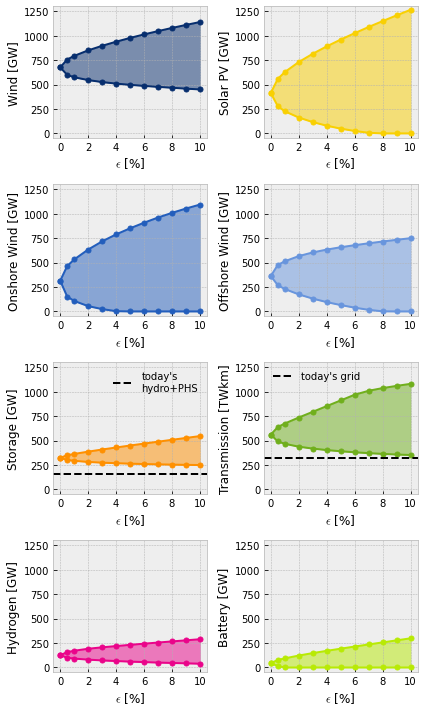

In [33]:
clt.plot_space(n, investments, line_volume, link_volume, fn=f"{d}space.pdf")

In [34]:
clt.plot_space_presentation(n, investments, line_volume, link_volume, fn=f"{d}space-pres.pdf")

/home/ws/sp2668/bwss/playgrounds/pypsa-eur-mga/scripts/plotting/boundaries.py:196: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/bwss/playgrounds/pypsa-eur-mga/scripts/plotting/boundaries.py:152: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/bwss/playgrounds/pypsa-eur-mga/scripts/plotting/boundaries.py:196: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To contr

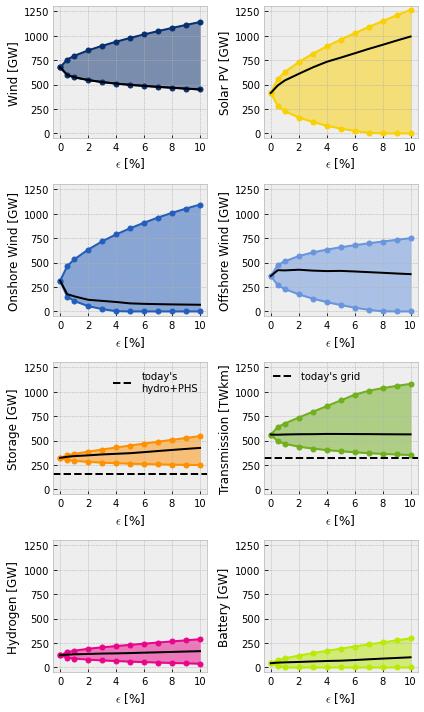

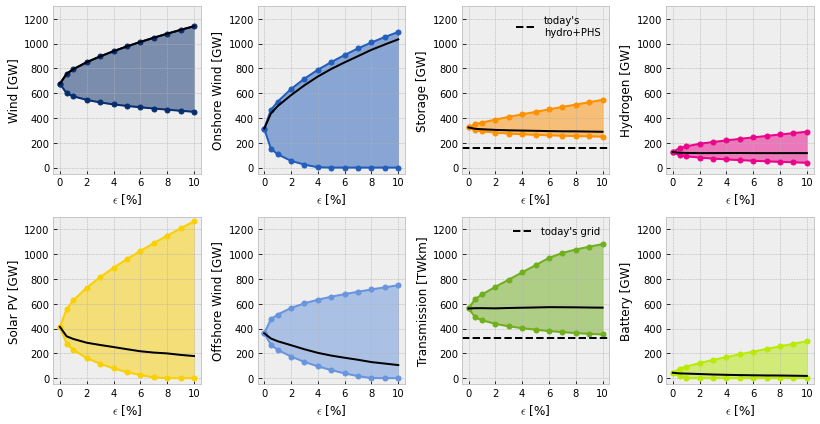

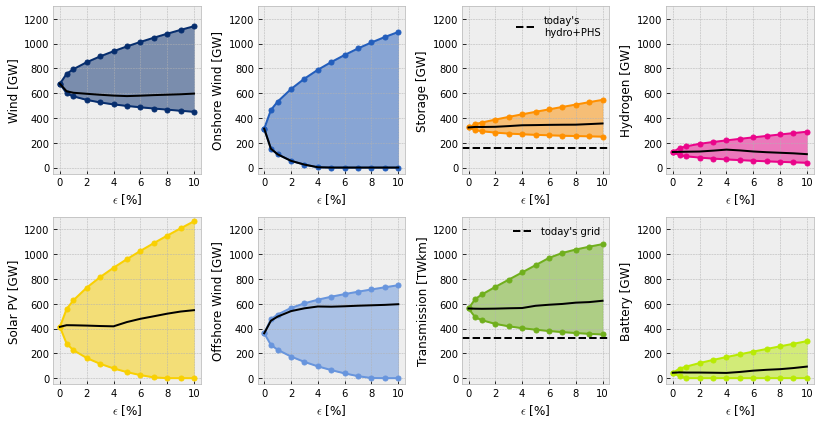

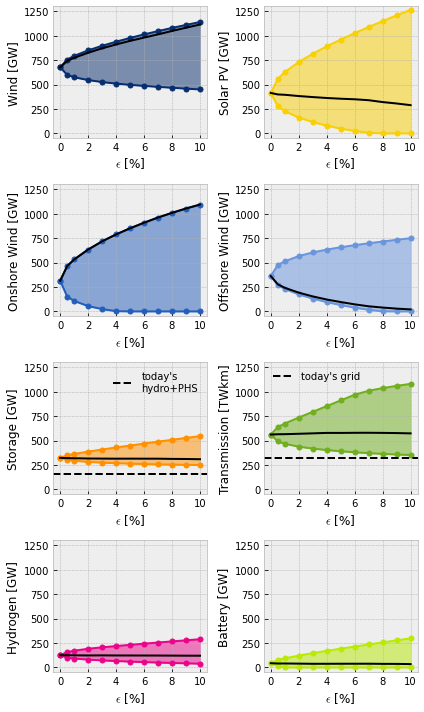

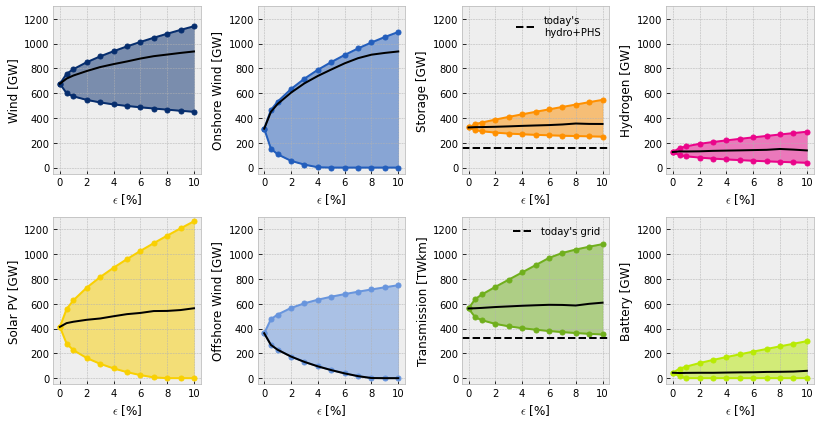

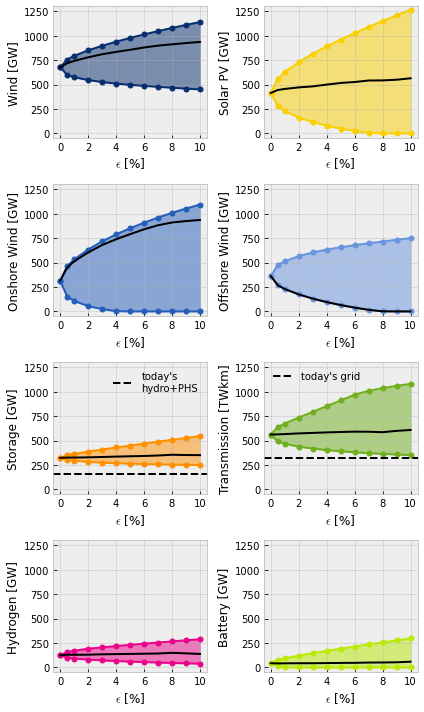

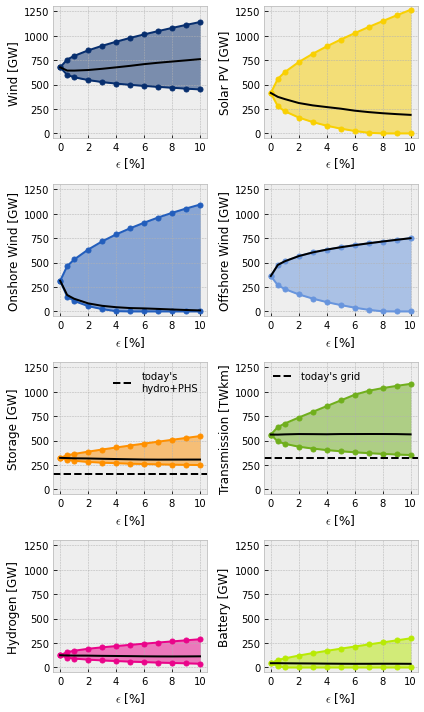

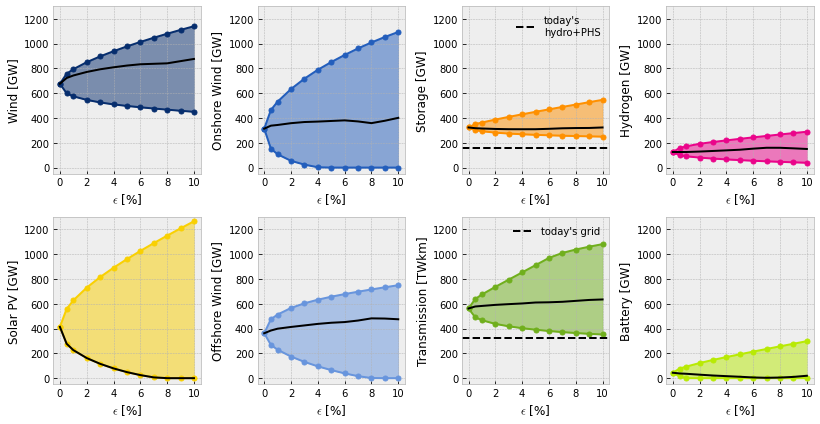

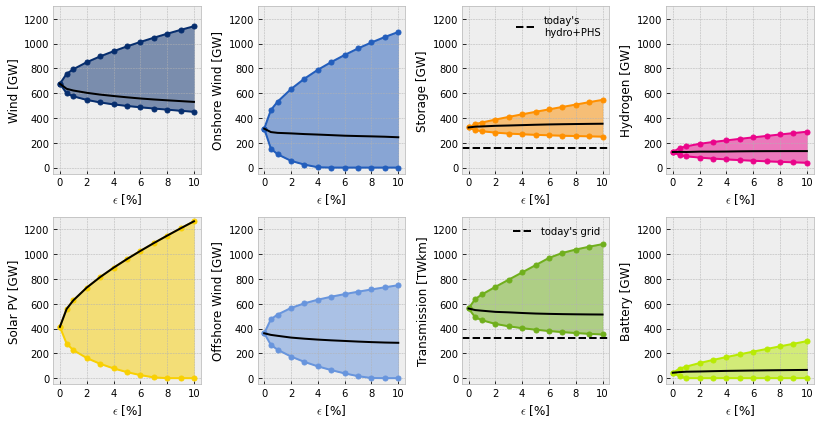

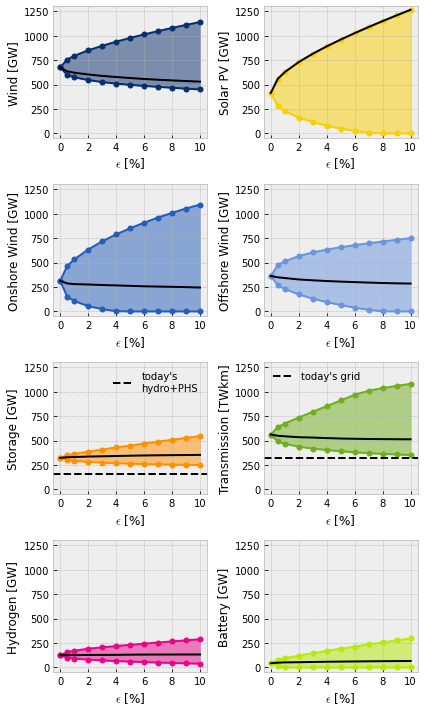

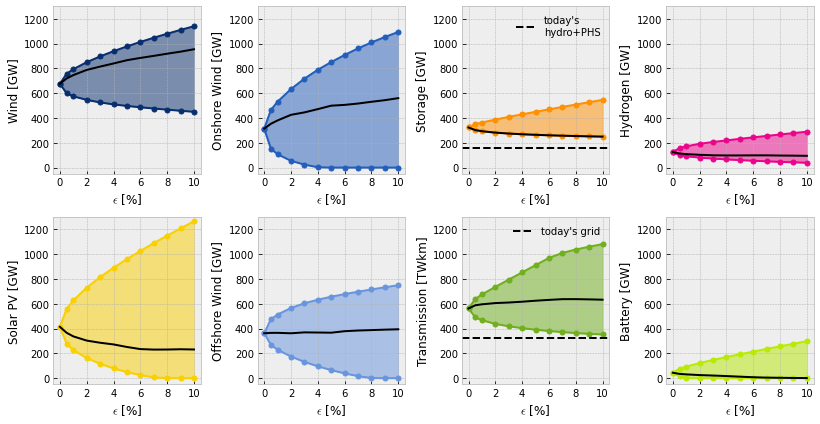

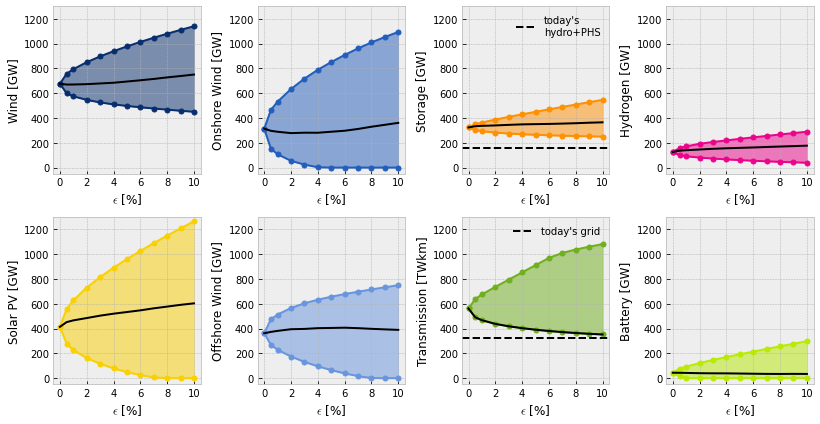

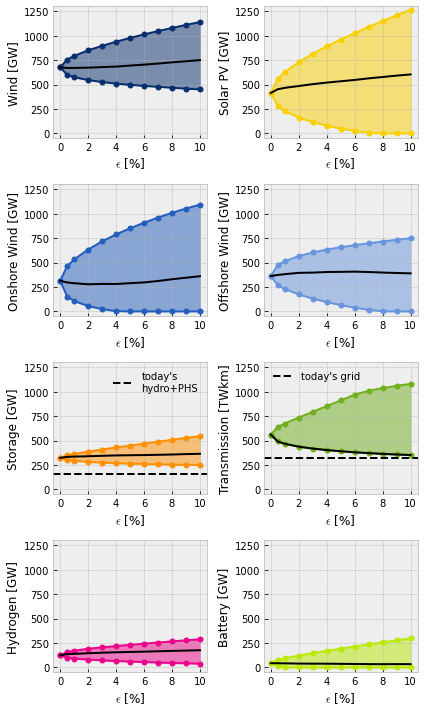

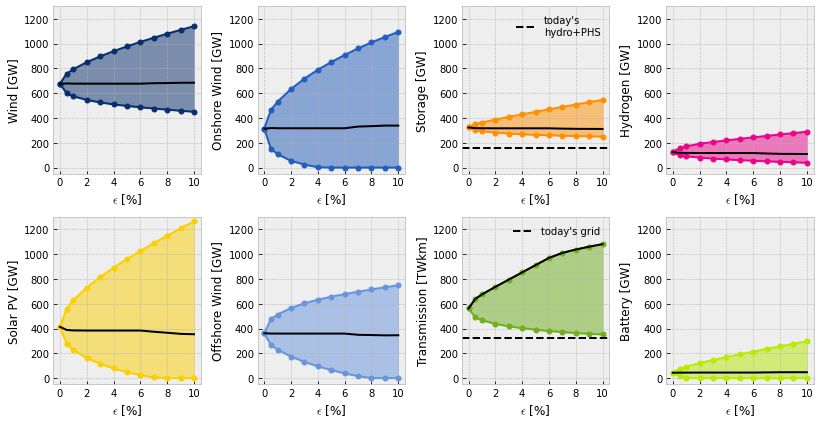

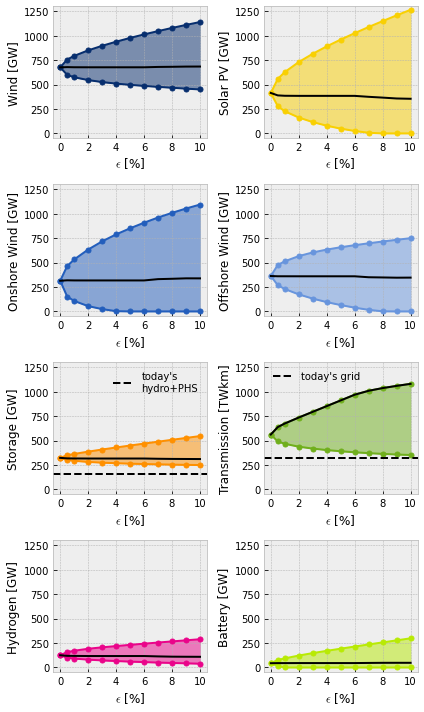

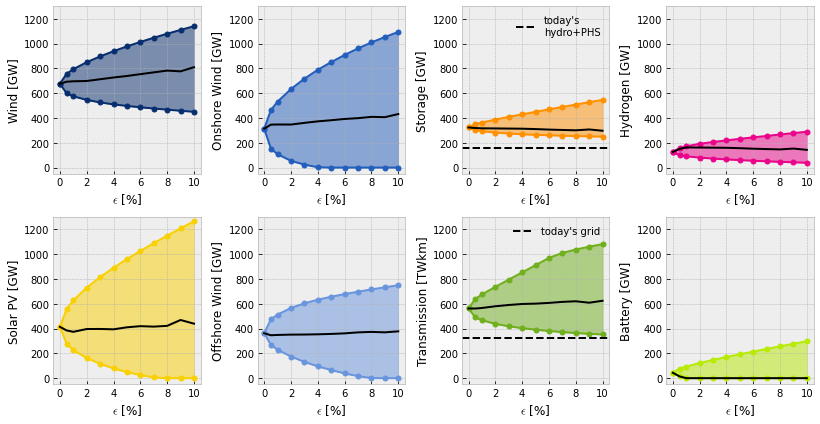

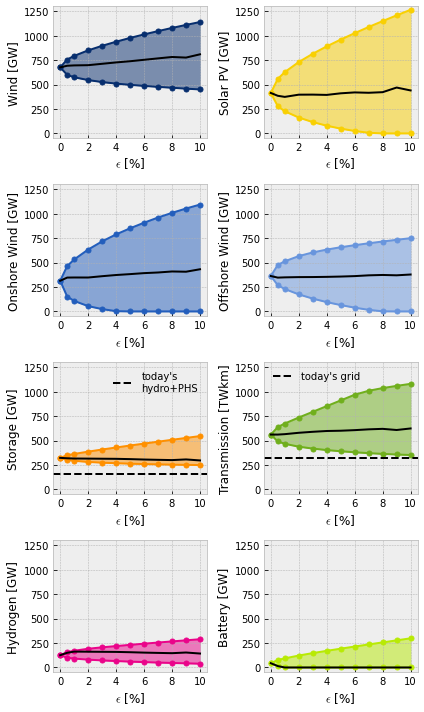

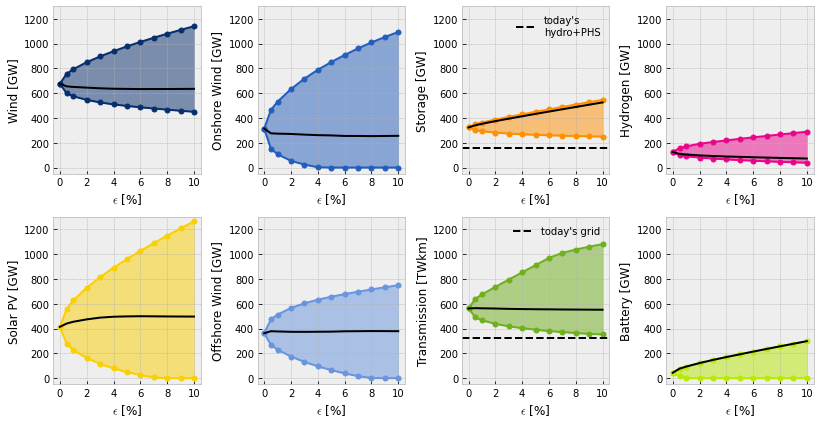

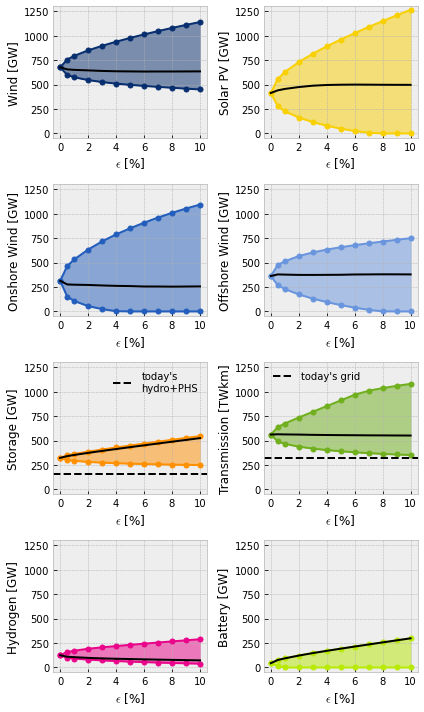

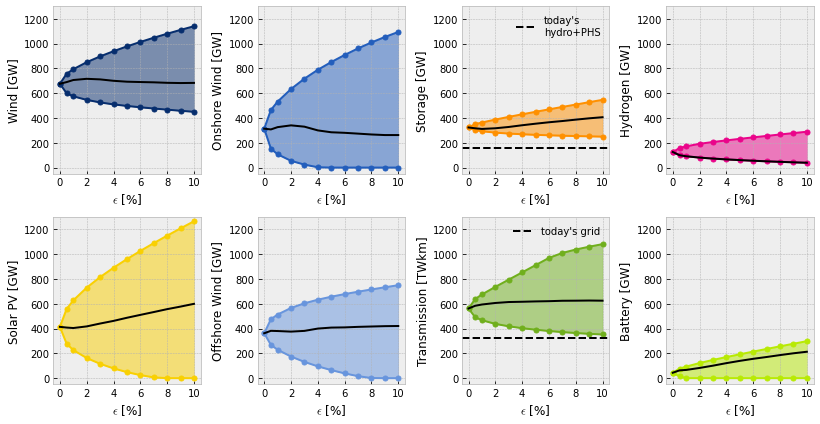

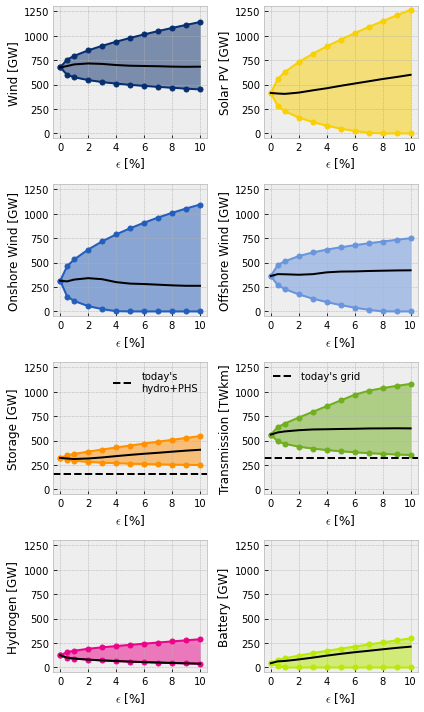

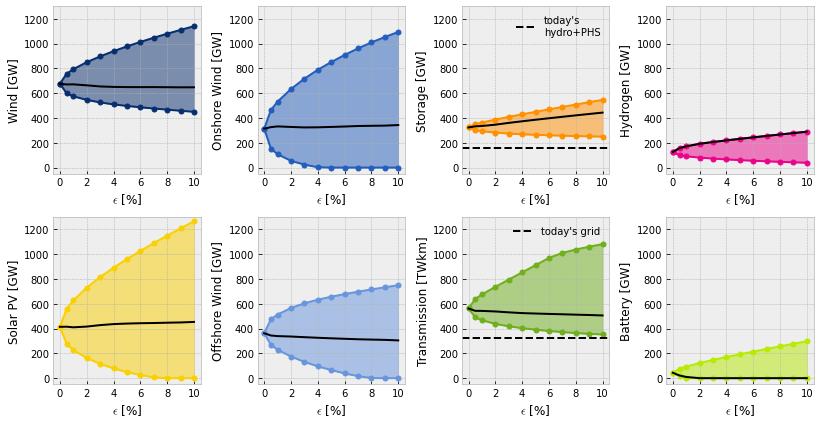

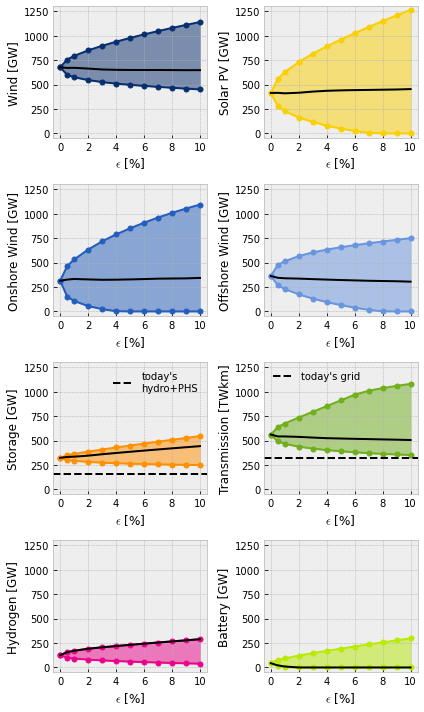

In [36]:
groups = ["wind", "onwind", "offwind", "solar", "all-StorageUnit", "all-Transmission", "battery", "H2"]
senses = ["min", "max"]
args = [n, investments, line_volume, link_volume]
for oc, ocs in product(groups, senses):
    kwargs = {
        "other_carrier": oc,
        "other_carrier_sense": ocs
    }
    clt.plot_space_presentation(*args, **kwargs, fn=f"{d}space-pres-{oc}-{ocs}.pdf")
    clt.plot_space(*args, **kwargs, fn=f"{d}space-{oc}-{ocs}.pdf")

/home/ws/sp2668/bwss/playgrounds/pypsa-eur-mga/scripts/plotting/bar.py:137: MatplotlibDeprecationWarning:

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.



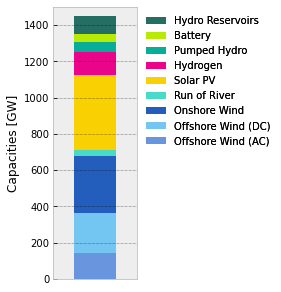

In [37]:
clt.plot_capacity_bar(n, fn=f"{d}capacity-bar.pdf")

In [ ]:
for tol in [0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
    fn = f"../results/networks/elec_s_100_ec_lcopt_2H_tol{tol}_cat-totals_obj-transmission++min.nc"
    n_tol = pypsa.Network(fn)
    clt.plot_network(n_tol, fn=fig_folder+f"map-tmin-{tol}.pdf")
    del n_tol

## Some Misc Checks

In [ ]:
(n.lines.s_nom_opt * n.lines.length / 1e6).sum()

In [ ]:
(n.links.p_nom_opt * n.links.length / 1e6).sum()

In [ ]:
n.storage_units.groupby('carrier').sum().p_nom_opt / 1e3

In [ ]:
n.generators.groupby('carrier').sum().p_nom_opt / 1e3 # GW

In [ ]:
n.generators['energy'] = n.generators_t.p.multiply(n.snapshot_weightings, axis=0).sum()
n.generators.groupby('carrier').sum().energy / 1e6 # TWh

In [ ]:
c = aggregate_costs(n)
c = c.groupby(level=2).sum() / 1e9 # bn Euro
c

In [ ]:
load = n.loads_t.p_set.multiply(n.snapshot_weightings, axis=0).sum().sum() / 1e6 #TWh
load

In [ ]:
c.sum()

In [ ]:
c.sum() / load * 1e3 # EUR/MWh

In [ ]:
net.global_constraints.mu

In [ ]:
get_system_transmission_volume(n, '_opt')

In [ ]:
n.generators.groupby("carrier").sum().p_nom_max / 1e3